# Module 3: Image Quality Assessments (IQA)

In [1]:
import torch
import numpy as np
import lpips
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import pandas as pd
from torchvision.io import read_image
from torchvision.transforms.functional import convert_image_dtype
from pypiqe import piqe
import torch
import torchvision.transforms.functional as TF
import cv2  
from cv2 import grabCut


In [2]:
#loading image
ground_truth_image = read_image("./data/image_6.jpg")  # returns [C, H, W], uint8

# loading MSE dictionary
mse_dict = torch.load("./results_for_plotting/mse_values.pt")

# list of keys in the dictionary
recon_keys = list(mse_dict.keys())

#folder containing the reconstructions
recon_folder = "./results_for_plotting/"

# loading all reconstruction into dictionary
recons = {key: torch.load(f"{recon_folder}{key}.pt").to("cpu") for key in recon_keys}


In [3]:
loss_fn_alex = lpips.LPIPS(net='alex')  # Load LPIPS model

#define the metrics
def compute_psnr(x, y):
    x_np = x.squeeze().permute(1, 2, 0).numpy()
    y_np = y.squeeze().permute(1, 2, 0).numpy()
    return psnr(y_np, x_np, data_range=1.0)

def compute_ssim(x, y):
    x_np = x.squeeze().permute(1, 2, 0).numpy()
    y_np = y.squeeze().permute(1, 2, 0).numpy()
    return ssim(y_np, x_np, data_range=1.0, channel_axis=2)

def compute_lpips(x, y):
    return loss_fn_alex(x, y).item()

#for display later
def torch_to_numpy(img):
    # img should be [1, C, H, W]
    numpy_image = img.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
    return numpy_image




Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/Users/Jasthecoolbean/Desktop/A7/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/Jasthecoolbean/Desktop/A7/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /Users/Jasthecoolbean/Desktop/A7/venv/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth


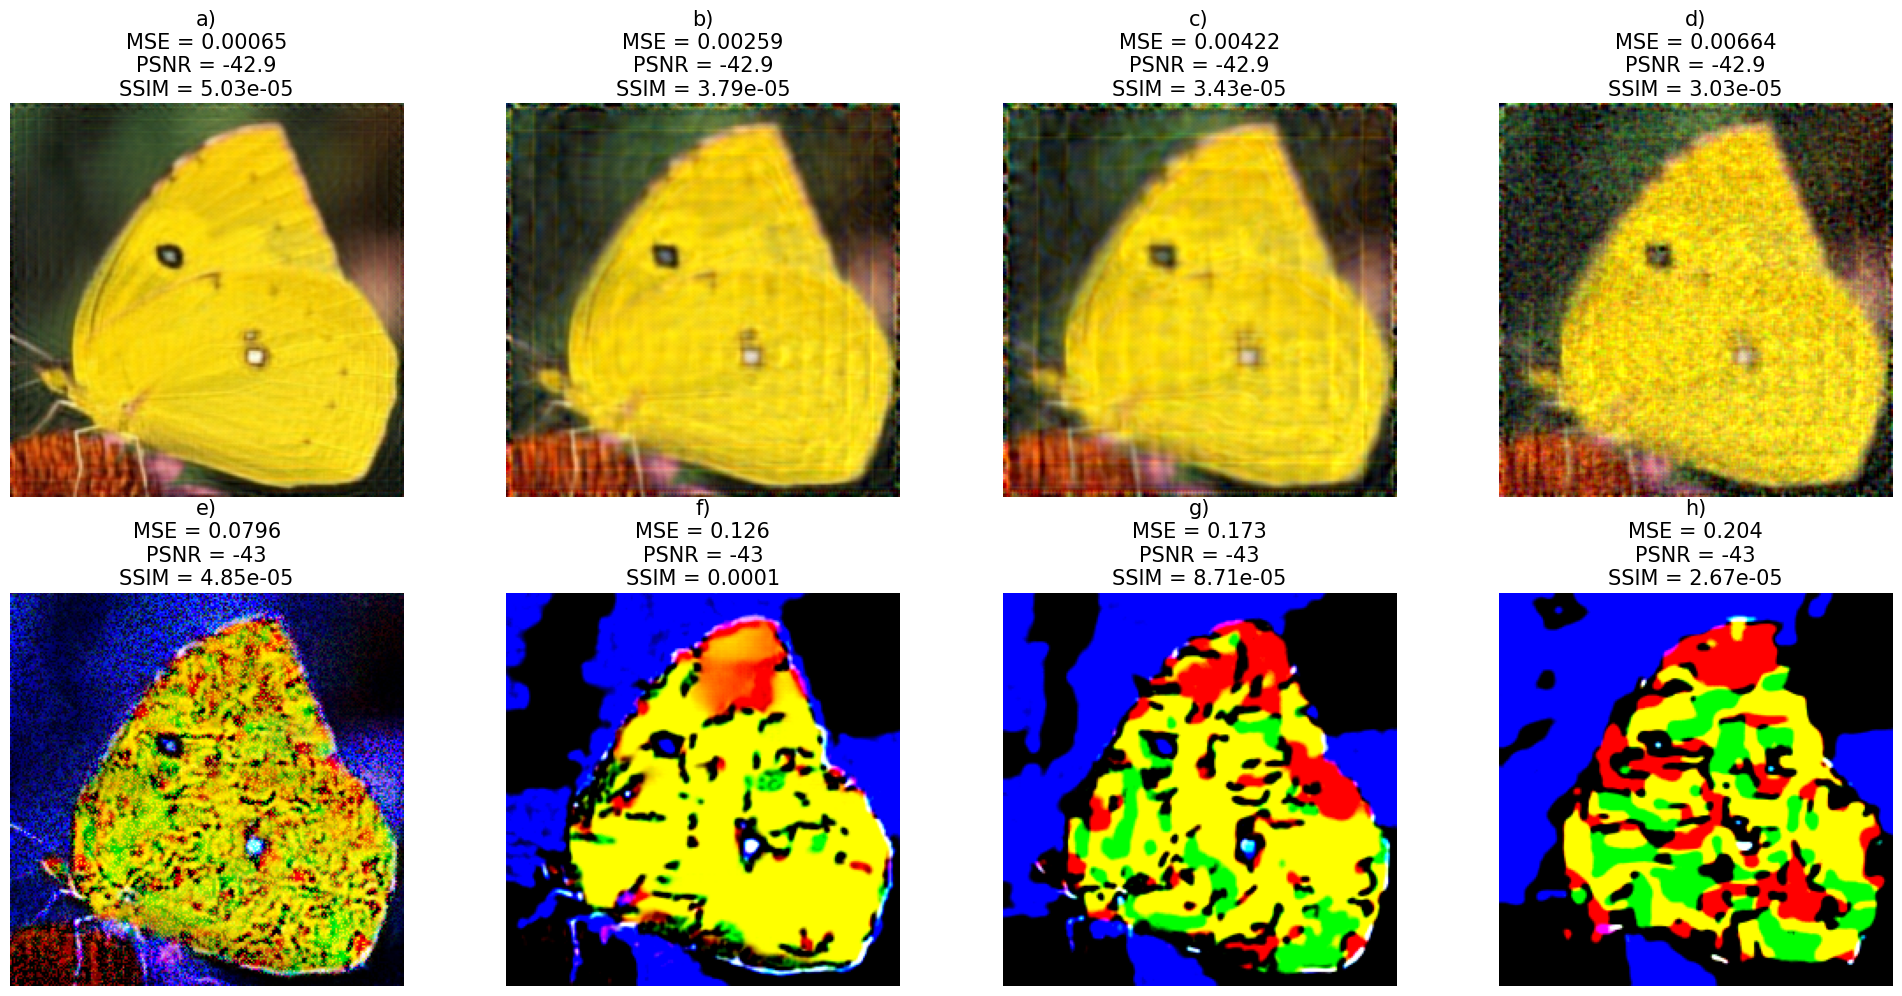

In [4]:
#plotting
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for i, key in enumerate(mse_dict.keys()):
    row = i // 4
    col = i % 4
    x = recons[key]  # [1, 3, H, W]
    y = ground_truth_image

    # compute metrics
    psnr_val = compute_psnr(x, y)
    ssim_val = compute_ssim(x, y)
    
    recon_img = torch_to_numpy(x)

    #list to be plotted as titles
    labels = ["a)","b)","c)","d)","e)","f)","g)","h)"]
    # Plot
    axs[row, col].imshow(recon_img)
    axs[row, col].axis("off")
    axs[row, col].set_title(
        f"{labels[i]}\n"
        f"MSE = {mse_dict[key]:.3g}\n"
        f"PSNR = {psnr_val:.3g}\n"
        f"SSIM = {ssim_val:.3g}",
        fontsize=15
    )

plt.tight_layout()
plt.show()

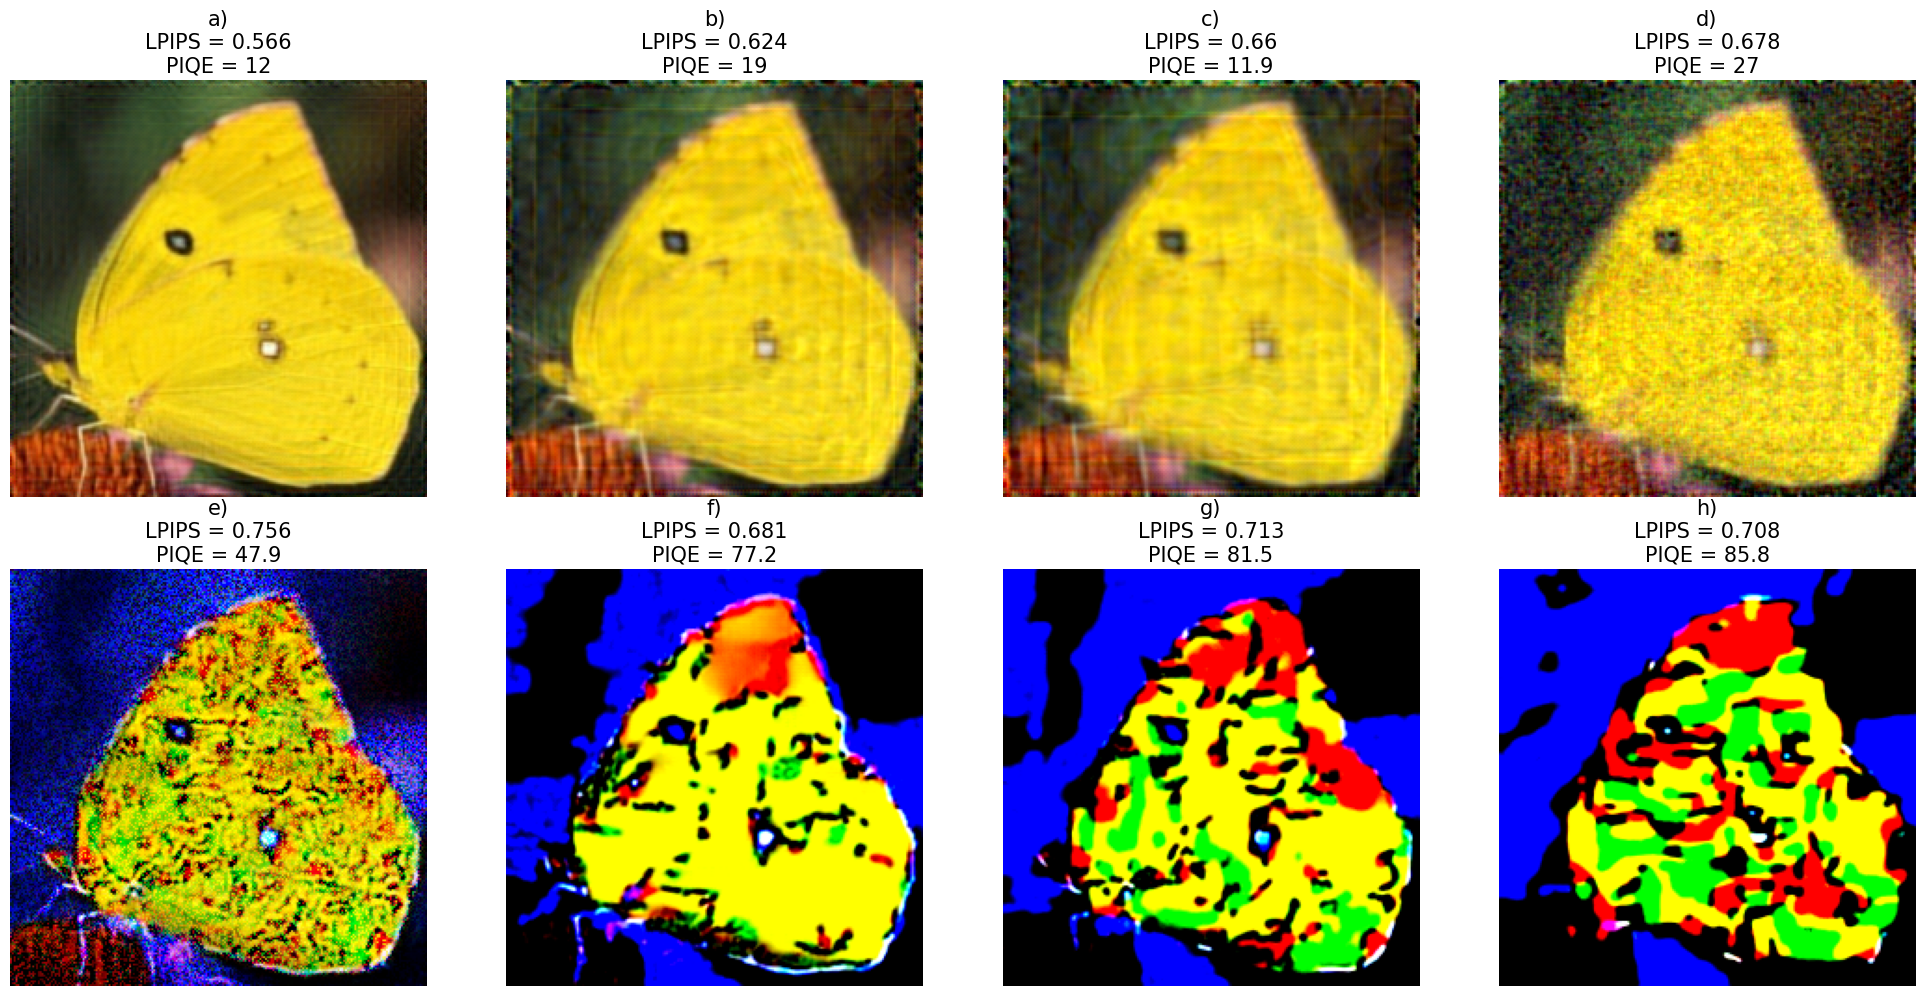

In [5]:

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for i, key in enumerate(mse_dict.keys()):
    row = i // 4
    col = i % 4
    x = recons[key] 
    y = ground_truth_image

    recon_img = torch_to_numpy(x)
    
    lpip_val = compute_lpips(x,y)
    piqe_val = piqe(recon_img)[0] 


    #list 
    labels = ["a)","b)","c)","d)","e)","f)","g)","h)"]
    # Plot
    axs[row, col].imshow(recon_img)
    axs[row, col].axis("off")
    axs[row, col].set_title(
        f"{labels[i]}\n"
        f"LPIPS = {lpip_val:.3g}\n"
        f"PIQE = {piqe_val:.3g}",
        fontsize=15
    )

plt.tight_layout()
plt.show()

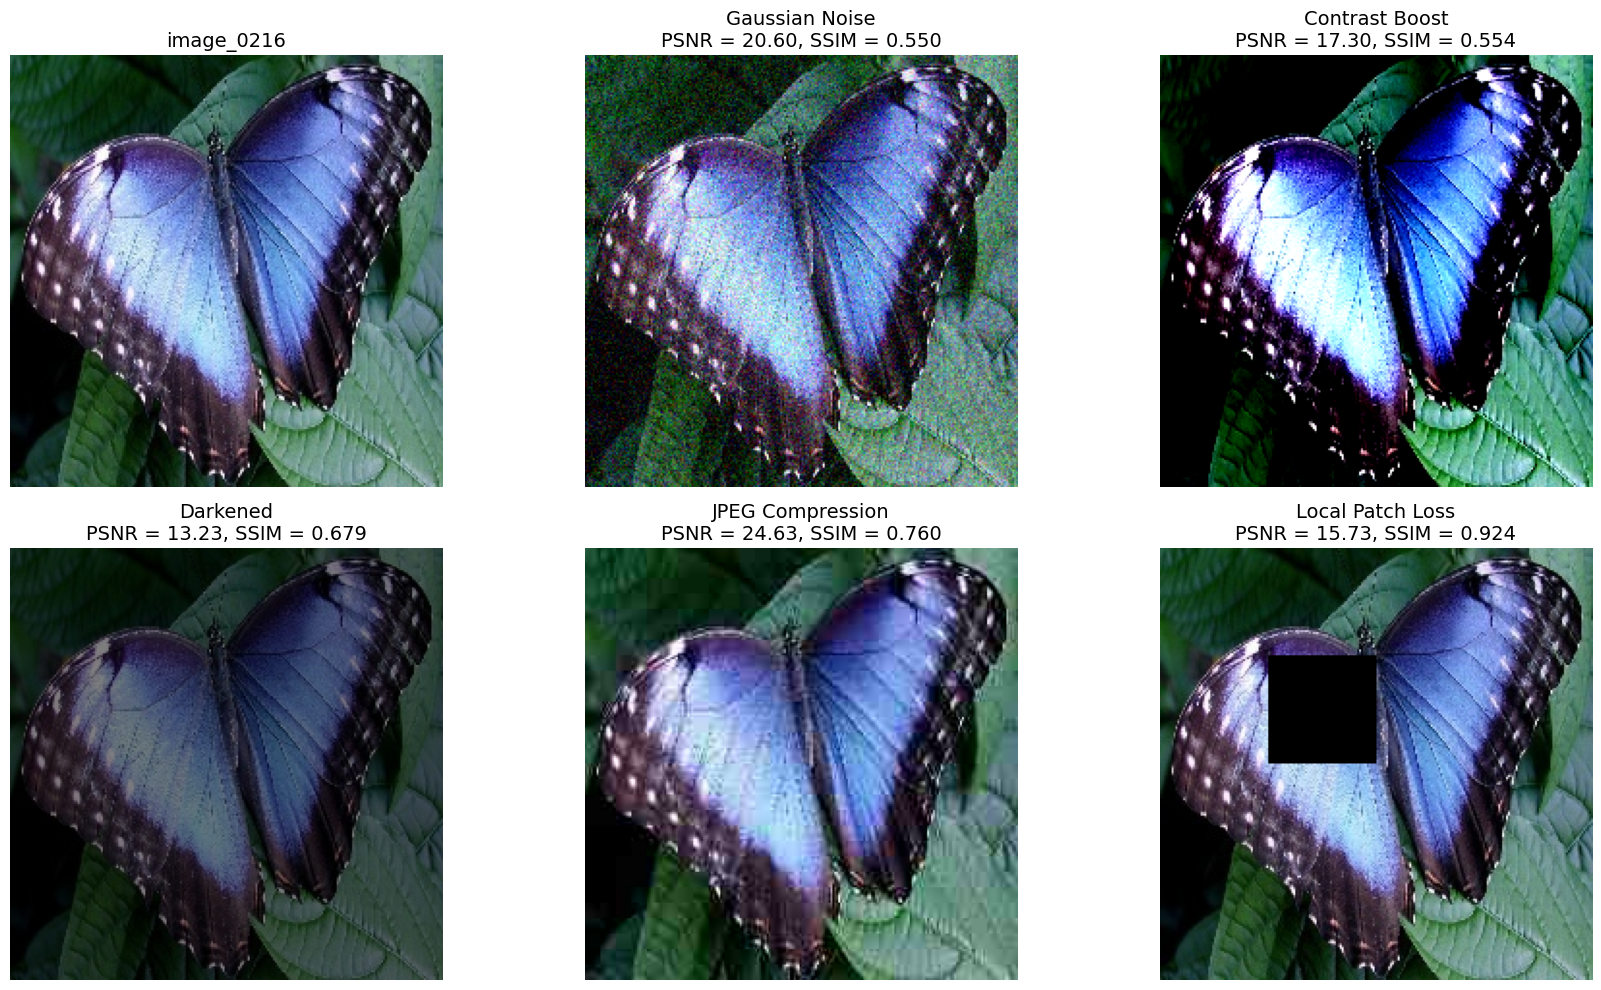

In [16]:
#loading new image
ground_truth_image = read_image("./data/image_216.jpg")
original = ground_truth_image.clone()
original_np = torch_to_numpy(original)
original_np = original_np.astype(np.float32) / 255.0

#applying diff degradations
gaussian_noise = np.clip(original_np + np.random.normal(0, 0.1, original_np.shape), 0, 1)
contrast = np.clip((original_np - 0.5) * 2 + 0.5, 0, 1)
luminance = np.clip(original_np * 0.5, 0, 1)

jpeg_input = (original_np * 255).astype(np.uint8)
_, jpeg_encoded = cv2.imencode('.jpg', jpeg_input, [int(cv2.IMWRITE_JPEG_QUALITY), 20])
jpeg_decoded = cv2.imdecode(jpeg_encoded, cv2.IMREAD_COLOR)
jpeg_decoded = jpeg_decoded.astype(np.float32) / 255.0

local_loss = original_np.copy()
h, w = local_loss.shape[:2]
local_loss[h//4:h//2, w//4:w//2, :] = 0  # Mask patch

degraded_images = [
    ("image_0216", original_np),
    ("Gaussian Noise", gaussian_noise),
    ("Contrast Boost", contrast),
    ("Darkened", luminance),
    ("JPEG Compression", jpeg_decoded),
    ("Local Patch Loss", local_loss)
]

# Plotting
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

for i, (name, img) in enumerate(degraded_images):
    row, col = i // 3, i % 3
    axs[row, col].imshow(img)
    axs[row, col].axis('off')

    if i == 0:
        axs[row, col].set_title(f"{name}", fontsize=14)
    else:
        psnr_val = psnr(original_np, img, data_range=1.0)
        ssim_val = ssim(original_np, img, channel_axis=2, data_range=1.0)
        axs[row, col].set_title(
            f"{name}\nPSNR = {psnr_val:.2f}, SSIM = {ssim_val:.3f}",
            fontsize=14
        )

plt.tight_layout()
plt.show()



In [17]:
#using the same grabcut background removal
def remove_background_grabcut(img_rgb):
    """
    img_rgb: float32 numpy array in range [0, 1], shape (H, W, 3)
    Returns: RGB image with white background (float32, range [0, 1])
    """
    img_rgb_uint8 = (img_rgb * 255).astype(np.uint8)
    img_bgr = cv2.cvtColor(img_rgb_uint8, cv2.COLOR_RGB2BGR)

    h, w = img_bgr.shape[:2]
    rect = (10, 10, w - 20, h - 20)
    mask = np.zeros((h, w), np.uint8)
    bgModel = np.zeros((1, 65), np.float64)
    fgModel = np.zeros((1, 65), np.float64)

    cv2.grabCut(img_bgr, mask, rect, bgModel, fgModel, 5, cv2.GC_INIT_WITH_RECT)
    final_mask = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 1, 0).astype("uint8")

    result = img_bgr * final_mask[:, :, np.newaxis]
    white_bg = np.full_like(img_bgr, 255)
    combined = np.where(final_mask[:, :, np.newaxis] == 0, white_bg, result)

    combined_rgb = cv2.cvtColor(combined, cv2.COLOR_BGR2RGB)
    return combined_rgb.astype(np.float32) / 255.0


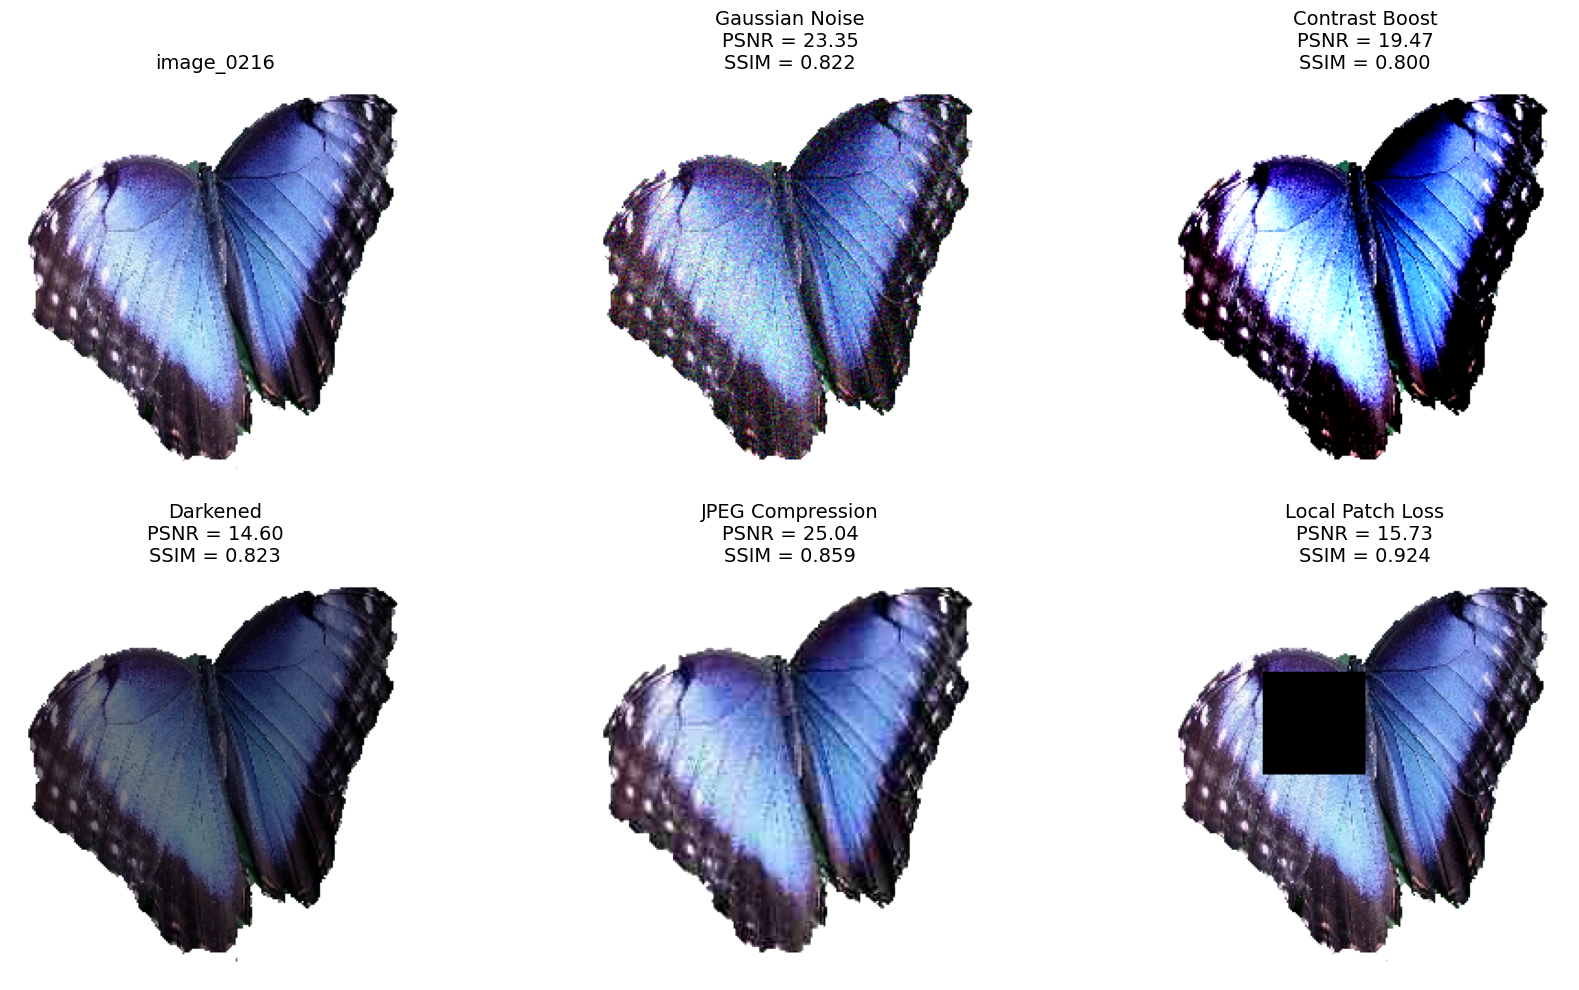

In [21]:
# this psnr and ssim applies it to a numpy array
def compute_psnr_np(x_np, y_np):
    return psnr(y_np, x_np, data_range=1.0)

def compute_ssim_np(x_np, y_np):
    return ssim(y_np, x_np, data_range=1.0, channel_axis=2)

# Convert ground truth to numpy and apply GrabCut to it
ground_truth_np = torch_to_numpy(ground_truth_image)
ground_truth_np = ground_truth_np.astype(np.float32) / 255.0
original_np = remove_background_grabcut(ground_truth_np)

# Apply degradations on original, then apply GrabCut to degraded versions
gaussian_noise = np.clip(original_np + np.random.normal(0, 0.1, original_np.shape), 0, 1)
contrast = np.clip((original_np - 0.5) * 2 + 0.5, 0, 1)
luminance = np.clip(original_np * 0.5, 0, 1)

jpeg_input = (original_np * 255).astype(np.uint8)
_, jpeg_encoded = cv2.imencode('.jpg', jpeg_input, [int(cv2.IMWRITE_JPEG_QUALITY), 20])
jpeg_decoded = cv2.imdecode(jpeg_encoded, cv2.IMREAD_COLOR).astype(np.float32) / 255.0

local_loss = original_np.copy()
h, w = local_loss.shape[:2]
local_loss[h//4:h//2, w//4:w//2, :] = 0

# Apply GrabCut to all degraded images
degraded_images = [
    ("image_0216", original_np),
    ("Gaussian Noise", remove_background_grabcut(gaussian_noise)),
    ("Contrast Boost", remove_background_grabcut(contrast)),
    ("Darkened", remove_background_grabcut(luminance)),
    ("JPEG Compression", remove_background_grabcut(jpeg_decoded)),
    ("Local Patch Loss", remove_background_grabcut(local_loss))
]

# Plotting
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

for i, (name, img) in enumerate(degraded_images):
    row, col = i // 3, i % 3
    axs[row, col].imshow(img)
    axs[row, col].axis('off')

    if i == 0:
        axs[row, col].set_title(f"{name}", fontsize=14)
    else:
        psnr_val = compute_psnr_np(img, degraded_images[0][1])
        ssim_val = compute_ssim_np(img, degraded_images[0][1])
        axs[row, col].set_title(
            f"{name}\nPSNR = {psnr_val:.2f}\nSSIM = {ssim_val:.3f}",
            fontsize=14
        )

plt.tight_layout()
plt.show()
